<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:03:55] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


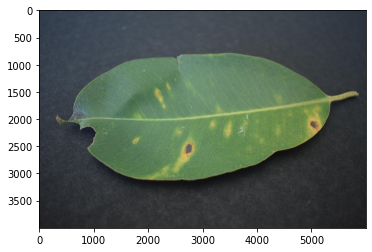

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

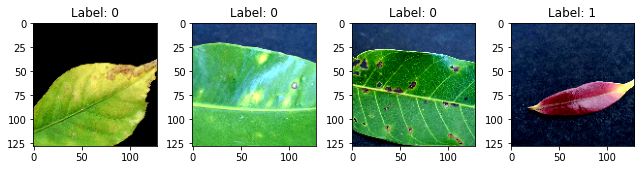

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:04:01] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:04:03] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2664686933679248 samples/sec                   batch loss = 1.0092040300369263 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2361972947544337 samples/sec                   batch loss = 1.2333451509475708 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2723730616221975 samples/sec                   batch loss = 0.5651071071624756 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2656596489859577 samples/sec                   batch loss = 0.4747627377510071 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2627002018623479 samples/sec                   batch loss = 1.3169376850128174 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.267594647535857 samples/sec                   batch loss = 0.36866843700408936 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2568860956115635 samples/sec                   batch loss = 0.5824588537216187 | accuracy = 0.6


Epoch[1] Batch[40] Speed: 1.2716393438646787 samples/sec                   batch loss = 0.2798759341239929 | accuracy = 0.61875


Epoch[1] Batch[45] Speed: 1.2740813036728411 samples/sec                   batch loss = 0.9443302750587463 | accuracy = 0.6222222222222222


Epoch[1] Batch[50] Speed: 1.2737178013075918 samples/sec                   batch loss = 0.4517098665237427 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2714685731452198 samples/sec                   batch loss = 0.4115353226661682 | accuracy = 0.6409090909090909


Epoch[1] Batch[60] Speed: 1.2742018720812573 samples/sec                   batch loss = 1.1239049434661865 | accuracy = 0.6333333333333333


Epoch[1] Batch[65] Speed: 1.2721233791383855 samples/sec                   batch loss = 0.5711625814437866 | accuracy = 0.6384615384615384


Epoch[1] Batch[70] Speed: 1.2733986745348136 samples/sec                   batch loss = 1.6205403804779053 | accuracy = 0.6392857142857142


Epoch[1] Batch[75] Speed: 1.271088262408274 samples/sec                   batch loss = 0.38573235273361206 | accuracy = 0.6333333333333333


Epoch[1] Batch[80] Speed: 1.2690482238167717 samples/sec                   batch loss = 0.5537728071212769 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.2698322930157246 samples/sec                   batch loss = 0.6119233965873718 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.2678279923325242 samples/sec                   batch loss = 0.808593213558197 | accuracy = 0.625


Epoch[1] Batch[95] Speed: 1.2651077269435445 samples/sec                   batch loss = 1.0205868482589722 | accuracy = 0.631578947368421


Epoch[1] Batch[100] Speed: 1.270262054330355 samples/sec                   batch loss = 0.8245585560798645 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.271220497657058 samples/sec                   batch loss = 0.8883206844329834 | accuracy = 0.6333333333333333


Epoch[1] Batch[110] Speed: 1.2640813245069038 samples/sec                   batch loss = 0.8928623795509338 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.2727683352484924 samples/sec                   batch loss = 0.5660129189491272 | accuracy = 0.6304347826086957


Epoch[1] Batch[120] Speed: 1.274253841586243 samples/sec                   batch loss = 0.5937914252281189 | accuracy = 0.6354166666666666


Epoch[1] Batch[125] Speed: 1.2696282822650717 samples/sec                   batch loss = 0.7346215844154358 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.2658094753790137 samples/sec                   batch loss = 0.6422138214111328 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2714755110163822 samples/sec                   batch loss = 0.3637257218360901 | accuracy = 0.6370370370370371


Epoch[1] Batch[140] Speed: 1.2752095970049036 samples/sec                   batch loss = 0.7433300614356995 | accuracy = 0.6375


Epoch[1] Batch[145] Speed: 1.2727211211635845 samples/sec                   batch loss = 1.2253625392913818 | accuracy = 0.6344827586206897


Epoch[1] Batch[150] Speed: 1.2665399211987833 samples/sec                   batch loss = 0.5802145600318909 | accuracy = 0.6383333333333333


Epoch[1] Batch[155] Speed: 1.2675079793348316 samples/sec                   batch loss = 0.7852402329444885 | accuracy = 0.635483870967742


Epoch[1] Batch[160] Speed: 1.2733051226932124 samples/sec                   batch loss = 0.23028463125228882 | accuracy = 0.640625


Epoch[1] Batch[165] Speed: 1.2733795378125174 samples/sec                   batch loss = 0.28066369891166687 | accuracy = 0.6454545454545455


Epoch[1] Batch[170] Speed: 1.2740612756578376 samples/sec                   batch loss = 0.513931155204773 | accuracy = 0.6485294117647059


Epoch[1] Batch[175] Speed: 1.247540364962391 samples/sec                   batch loss = 0.2501659691333771 | accuracy = 0.6471428571428571


Epoch[1] Batch[180] Speed: 1.2686236000574378 samples/sec                   batch loss = 0.4842304289340973 | accuracy = 0.65


Epoch[1] Batch[185] Speed: 1.264683352301706 samples/sec                   batch loss = 0.4923540949821472 | accuracy = 0.6513513513513514


Epoch[1] Batch[190] Speed: 1.267413759069688 samples/sec                   batch loss = 0.8071805238723755 | accuracy = 0.6552631578947369


Epoch[1] Batch[195] Speed: 1.2651351065005028 samples/sec                   batch loss = 0.274426132440567 | accuracy = 0.6564102564102564


Epoch[1] Batch[200] Speed: 1.2693235894438306 samples/sec                   batch loss = 1.0179193019866943 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.2682425923249367 samples/sec                   batch loss = 0.5151458382606506 | accuracy = 0.6548780487804878


Epoch[1] Batch[210] Speed: 1.2686194751641275 samples/sec                   batch loss = 0.20604166388511658 | accuracy = 0.655952380952381


Epoch[1] Batch[215] Speed: 1.2617249529162378 samples/sec                   batch loss = 0.7872251272201538 | accuracy = 0.6558139534883721


Epoch[1] Batch[220] Speed: 1.2644344865638326 samples/sec                   batch loss = 0.5142897367477417 | accuracy = 0.6556818181818181


Epoch[1] Batch[225] Speed: 1.2636405061727558 samples/sec                   batch loss = 0.2528396546840668 | accuracy = 0.6588888888888889


Epoch[1] Batch[230] Speed: 1.2692744219644214 samples/sec                   batch loss = 0.39794987440109253 | accuracy = 0.6608695652173913


Epoch[1] Batch[235] Speed: 1.26617631298914 samples/sec                   batch loss = 0.5163483023643494 | accuracy = 0.6617021276595745


Epoch[1] Batch[240] Speed: 1.2601007677074663 samples/sec                   batch loss = 1.394498586654663 | accuracy = 0.6625


Epoch[1] Batch[245] Speed: 1.2727412036182193 samples/sec                   batch loss = 0.4068710207939148 | accuracy = 0.6632653061224489


Epoch[1] Batch[250] Speed: 1.2618782150139989 samples/sec                   batch loss = 1.007672905921936 | accuracy = 0.661


Epoch[1] Batch[255] Speed: 1.26201708458926 samples/sec                   batch loss = 0.17534585297107697 | accuracy = 0.6637254901960784


Epoch[1] Batch[260] Speed: 1.2690352649898653 samples/sec                   batch loss = 0.5335759520530701 | accuracy = 0.6653846153846154


Epoch[1] Batch[265] Speed: 1.2660080571618255 samples/sec                   batch loss = 0.3726738691329956 | accuracy = 0.6660377358490566


Epoch[1] Batch[270] Speed: 1.2684938226650775 samples/sec                   batch loss = 0.602506160736084 | accuracy = 0.6620370370370371


Epoch[1] Batch[275] Speed: 1.267669737636469 samples/sec                   batch loss = 0.416062593460083 | accuracy = 0.6645454545454546


Epoch[1] Batch[280] Speed: 1.270020025437923 samples/sec                   batch loss = 1.0112152099609375 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2728635464904068 samples/sec                   batch loss = 0.6924427151679993 | accuracy = 0.6622807017543859


Epoch[1] Batch[290] Speed: 1.2683840170097505 samples/sec                   batch loss = 0.4155433475971222 | accuracy = 0.6620689655172414


Epoch[1] Batch[295] Speed: 1.2662016364485076 samples/sec                   batch loss = 1.6203259229660034 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.2734482587183629 samples/sec                   batch loss = 1.42658269405365 | accuracy = 0.6608333333333334


Epoch[1] Batch[305] Speed: 1.2695997471276215 samples/sec                   batch loss = 0.3694015145301819 | accuracy = 0.6614754098360656


Epoch[1] Batch[310] Speed: 1.2762098887535385 samples/sec                   batch loss = 0.7063956260681152 | accuracy = 0.6596774193548387


Epoch[1] Batch[315] Speed: 1.2720640601908975 samples/sec                   batch loss = 1.4982326030731201 | accuracy = 0.6587301587301587


Epoch[1] Batch[320] Speed: 1.2725674341314317 samples/sec                   batch loss = 0.573058009147644 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.270026466807937 samples/sec                   batch loss = 0.4129246175289154 | accuracy = 0.6592307692307692


Epoch[1] Batch[330] Speed: 1.270687872043674 samples/sec                   batch loss = 0.6089358329772949 | accuracy = 0.6606060606060606


Epoch[1] Batch[335] Speed: 1.2741474876788554 samples/sec                   batch loss = 0.39489126205444336 | accuracy = 0.664179104477612


Epoch[1] Batch[340] Speed: 1.2659921033655623 samples/sec                   batch loss = 0.30764463543891907 | accuracy = 0.6639705882352941


Epoch[1] Batch[345] Speed: 1.267324243645218 samples/sec                   batch loss = 0.7421827912330627 | accuracy = 0.6623188405797101


Epoch[1] Batch[350] Speed: 1.2731135196358747 samples/sec                   batch loss = 0.8546415567398071 | accuracy = 0.6621428571428571


Epoch[1] Batch[355] Speed: 1.2694446998131457 samples/sec                   batch loss = 0.26500600576400757 | accuracy = 0.6619718309859155


Epoch[1] Batch[360] Speed: 1.2667492530941784 samples/sec                   batch loss = 0.5330127477645874 | accuracy = 0.6631944444444444


Epoch[1] Batch[365] Speed: 1.271250261604281 samples/sec                   batch loss = 0.9868103265762329 | accuracy = 0.6636986301369863


Epoch[1] Batch[370] Speed: 1.26768899048539 samples/sec                   batch loss = 0.4697248041629791 | accuracy = 0.6628378378378378


Epoch[1] Batch[375] Speed: 1.2651535192035117 samples/sec                   batch loss = 0.4539839029312134 | accuracy = 0.666


Epoch[1] Batch[380] Speed: 1.2660192346119181 samples/sec                   batch loss = 0.42183810472488403 | accuracy = 0.6671052631578948


Epoch[1] Batch[385] Speed: 1.2686736764830764 samples/sec                   batch loss = 0.7226040959358215 | accuracy = 0.6675324675324675


Epoch[1] Batch[390] Speed: 1.2692425419626896 samples/sec                   batch loss = 0.774208664894104 | accuracy = 0.6685897435897435


Epoch[1] Batch[395] Speed: 1.2723503854807252 samples/sec                   batch loss = 0.43654370307922363 | accuracy = 0.6689873417721519


Epoch[1] Batch[400] Speed: 1.2702975442694169 samples/sec                   batch loss = 0.6233872771263123 | accuracy = 0.66875


Epoch[1] Batch[405] Speed: 1.2723025270012913 samples/sec                   batch loss = 0.9984700083732605 | accuracy = 0.6666666666666666


Epoch[1] Batch[410] Speed: 1.2766521387243475 samples/sec                   batch loss = 0.5085992217063904 | accuracy = 0.6689024390243903


Epoch[1] Batch[415] Speed: 1.2724215044277454 samples/sec                   batch loss = 0.5648593902587891 | accuracy = 0.6680722891566265


Epoch[1] Batch[420] Speed: 1.2672233505083934 samples/sec                   batch loss = 0.3420567810535431 | accuracy = 0.6672619047619047


Epoch[1] Batch[425] Speed: 1.2748048628426558 samples/sec                   batch loss = 0.8591992855072021 | accuracy = 0.6664705882352941


Epoch[1] Batch[430] Speed: 1.267517938392788 samples/sec                   batch loss = 0.5481123924255371 | accuracy = 0.6674418604651163


Epoch[1] Batch[435] Speed: 1.2692971806561812 samples/sec                   batch loss = 0.5929311513900757 | accuracy = 0.6672413793103448


Epoch[1] Batch[440] Speed: 1.2707914352623153 samples/sec                   batch loss = 0.659817636013031 | accuracy = 0.6659090909090909


Epoch[1] Batch[445] Speed: 1.270543816347327 samples/sec                   batch loss = 0.8553113341331482 | accuracy = 0.6651685393258427


Epoch[1] Batch[450] Speed: 1.272527763419223 samples/sec                   batch loss = 0.6777458786964417 | accuracy = 0.6666666666666666


Epoch[1] Batch[455] Speed: 1.2736205285218016 samples/sec                   batch loss = 0.5128145217895508 | accuracy = 0.6675824175824175


Epoch[1] Batch[460] Speed: 1.2697216789565546 samples/sec                   batch loss = 0.3147832751274109 | accuracy = 0.6695652173913044


Epoch[1] Batch[465] Speed: 1.2774180118265288 samples/sec                   batch loss = 0.6371728777885437 | accuracy = 0.6709677419354839


Epoch[1] Batch[470] Speed: 1.2676183037888205 samples/sec                   batch loss = 1.2644975185394287 | accuracy = 0.6718085106382978


Epoch[1] Batch[475] Speed: 1.2707287755731158 samples/sec                   batch loss = 0.6078234314918518 | accuracy = 0.671578947368421


Epoch[1] Batch[480] Speed: 1.2707420577561 samples/sec                   batch loss = 0.521317183971405 | accuracy = 0.6708333333333333


Epoch[1] Batch[485] Speed: 1.2709723263865216 samples/sec                   batch loss = 1.4839881658554077 | accuracy = 0.6695876288659793


Epoch[1] Batch[490] Speed: 1.2717171310606752 samples/sec                   batch loss = 0.4208628237247467 | accuracy = 0.6724489795918367


Epoch[1] Batch[495] Speed: 1.2724144597268223 samples/sec                   batch loss = 0.6007413268089294 | accuracy = 0.6727272727272727


Epoch[1] Batch[500] Speed: 1.269728982157726 samples/sec                   batch loss = 0.7443840503692627 | accuracy = 0.674


Epoch[1] Batch[505] Speed: 1.273924772965716 samples/sec                   batch loss = 0.5155059695243835 | accuracy = 0.6747524752475248


Epoch[1] Batch[510] Speed: 1.2695452745177538 samples/sec                   batch loss = 0.5859659910202026 | accuracy = 0.6735294117647059


Epoch[1] Batch[515] Speed: 1.2649647428698398 samples/sec                   batch loss = 1.3747798204421997 | accuracy = 0.6728155339805825


Epoch[1] Batch[520] Speed: 1.271759643326687 samples/sec                   batch loss = 0.45746204257011414 | accuracy = 0.6725961538461539


Epoch[1] Batch[525] Speed: 1.2652410107167407 samples/sec                   batch loss = 0.4772590100765228 | accuracy = 0.6723809523809524


Epoch[1] Batch[530] Speed: 1.2697200453572641 samples/sec                   batch loss = 0.49749866127967834 | accuracy = 0.6726415094339623


Epoch[1] Batch[535] Speed: 1.2651037202785138 samples/sec                   batch loss = 0.387015163898468 | accuracy = 0.6742990654205607


Epoch[1] Batch[540] Speed: 1.272878611643188 samples/sec                   batch loss = 0.8791793584823608 | accuracy = 0.674074074074074


Epoch[1] Batch[545] Speed: 1.2602330931732706 samples/sec                   batch loss = 0.4506411552429199 | accuracy = 0.6756880733944954


Epoch[1] Batch[550] Speed: 1.2656168752376726 samples/sec                   batch loss = 0.43919023871421814 | accuracy = 0.6759090909090909


Epoch[1] Batch[555] Speed: 1.2672087060656725 samples/sec                   batch loss = 0.6282932758331299 | accuracy = 0.6756756756756757


Epoch[1] Batch[560] Speed: 1.2685620172303542 samples/sec                   batch loss = 0.5163034796714783 | accuracy = 0.6758928571428572


Epoch[1] Batch[565] Speed: 1.2674817417968123 samples/sec                   batch loss = 0.7194386124610901 | accuracy = 0.6743362831858407


Epoch[1] Batch[570] Speed: 1.2699418689455333 samples/sec                   batch loss = 0.33633214235305786 | accuracy = 0.675


Epoch[1] Batch[575] Speed: 1.262542464550195 samples/sec                   batch loss = 0.3324345648288727 | accuracy = 0.6760869565217391


Epoch[1] Batch[580] Speed: 1.2650663259620059 samples/sec                   batch loss = 0.24411462247371674 | accuracy = 0.6775862068965517


Epoch[1] Batch[585] Speed: 1.264297942740859 samples/sec                   batch loss = 0.1945815086364746 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.2659359339177425 samples/sec                   batch loss = 0.4114255905151367 | accuracy = 0.6805084745762712


Epoch[1] Batch[595] Speed: 1.2692981409564787 samples/sec                   batch loss = 0.5366876125335693 | accuracy = 0.6815126050420168


Epoch[1] Batch[600] Speed: 1.2662556313573297 samples/sec                   batch loss = 0.6607446074485779 | accuracy = 0.6820833333333334


Epoch[1] Batch[605] Speed: 1.2668190776555306 samples/sec                   batch loss = 0.2834581732749939 | accuracy = 0.6826446280991736


Epoch[1] Batch[610] Speed: 1.2650643227574352 samples/sec                   batch loss = 0.5871224403381348 | accuracy = 0.6815573770491803


Epoch[1] Batch[615] Speed: 1.2628902041118037 samples/sec                   batch loss = 0.22810879349708557 | accuracy = 0.682520325203252


Epoch[1] Batch[620] Speed: 1.2607408825718813 samples/sec                   batch loss = 0.31839823722839355 | accuracy = 0.6830645161290323


Epoch[1] Batch[625] Speed: 1.2634904315385203 samples/sec                   batch loss = 0.38761866092681885 | accuracy = 0.6844


Epoch[1] Batch[630] Speed: 1.2596379419055883 samples/sec                   batch loss = 0.32043132185935974 | accuracy = 0.6845238095238095


Epoch[1] Batch[635] Speed: 1.264496431727003 samples/sec                   batch loss = 0.457955539226532 | accuracy = 0.6838582677165355


Epoch[1] Batch[640] Speed: 1.2630509760268829 samples/sec                   batch loss = 0.7365499138832092 | accuracy = 0.68359375


Epoch[1] Batch[645] Speed: 1.2642430667216655 samples/sec                   batch loss = 0.4636211693286896 | accuracy = 0.6829457364341085


Epoch[1] Batch[650] Speed: 1.265798015128721 samples/sec                   batch loss = 0.4202471971511841 | accuracy = 0.683076923076923


Epoch[1] Batch[655] Speed: 1.263840883298675 samples/sec                   batch loss = 0.37931081652641296 | accuracy = 0.683587786259542


Epoch[1] Batch[660] Speed: 1.2690172190644067 samples/sec                   batch loss = 0.663379430770874 | accuracy = 0.6833333333333333


Epoch[1] Batch[665] Speed: 1.2633318308384538 samples/sec                   batch loss = 0.4463309645652771 | accuracy = 0.6842105263157895


Epoch[1] Batch[670] Speed: 1.265672347999061 samples/sec                   batch loss = 0.3531617224216461 | accuracy = 0.6835820895522388


Epoch[1] Batch[675] Speed: 1.2647663928824806 samples/sec                   batch loss = 0.2531769275665283 | accuracy = 0.6840740740740741


Epoch[1] Batch[680] Speed: 1.2672610638994397 samples/sec                   batch loss = 0.43539872765541077 | accuracy = 0.6845588235294118


Epoch[1] Batch[685] Speed: 1.2660254443916972 samples/sec                   batch loss = 0.2535419464111328 | accuracy = 0.6846715328467153


Epoch[1] Batch[690] Speed: 1.2710699654511615 samples/sec                   batch loss = 0.5368660688400269 | accuracy = 0.6858695652173913


Epoch[1] Batch[695] Speed: 1.275329991282532 samples/sec                   batch loss = 0.3418927788734436 | accuracy = 0.6866906474820144


Epoch[1] Batch[700] Speed: 1.2679240948198822 samples/sec                   batch loss = 0.7196162939071655 | accuracy = 0.6860714285714286


Epoch[1] Batch[705] Speed: 1.2644412525863924 samples/sec                   batch loss = 0.7206019759178162 | accuracy = 0.6868794326241134


Epoch[1] Batch[710] Speed: 1.2671962633410967 samples/sec                   batch loss = 0.8354203701019287 | accuracy = 0.6866197183098591


Epoch[1] Batch[715] Speed: 1.2640533238742144 samples/sec                   batch loss = 0.5452044010162354 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2711406523988389 samples/sec                   batch loss = 1.4196921586990356 | accuracy = 0.6878472222222223


Epoch[1] Batch[725] Speed: 1.2715919243697147 samples/sec                   batch loss = 0.6898306012153625 | accuracy = 0.6879310344827586


Epoch[1] Batch[730] Speed: 1.2657671689860028 samples/sec                   batch loss = 0.4536220133304596 | accuracy = 0.6886986301369863


Epoch[1] Batch[735] Speed: 1.2645098698635082 samples/sec                   batch loss = 0.6874373555183411 | accuracy = 0.6877551020408164


Epoch[1] Batch[740] Speed: 1.267465942343545 samples/sec                   batch loss = 0.33523067831993103 | accuracy = 0.6881756756756757


Epoch[1] Batch[745] Speed: 1.2676556575649554 samples/sec                   batch loss = 0.6838734745979309 | accuracy = 0.6875838926174497


Epoch[1] Batch[750] Speed: 1.2715216690589337 samples/sec                   batch loss = 0.8715563416481018 | accuracy = 0.687


Epoch[1] Batch[755] Speed: 1.2675782706471803 samples/sec                   batch loss = 0.6415952444076538 | accuracy = 0.6874172185430464


Epoch[1] Batch[760] Speed: 1.2719891236739322 samples/sec                   batch loss = 0.30692702531814575 | accuracy = 0.687828947368421


Epoch[1] Batch[765] Speed: 1.2705467991334312 samples/sec                   batch loss = 0.6195429563522339 | accuracy = 0.6879084967320261


Epoch[1] Batch[770] Speed: 1.2636286092920737 samples/sec                   batch loss = 0.4551082253456116 | accuracy = 0.6873376623376624


Epoch[1] Batch[775] Speed: 1.258946985484739 samples/sec                   batch loss = 0.6757723689079285 | accuracy = 0.6864516129032258


Epoch[1] Batch[780] Speed: 1.2590641394752238 samples/sec                   batch loss = 0.2879239618778229 | accuracy = 0.6875


Epoch[1] Batch[785] Speed: 1.2668181211026892 samples/sec                   batch loss = 0.629246711730957 | accuracy = 0.6878980891719745


[Epoch 1] training: accuracy=0.6881345177664975
[Epoch 1] time cost: 648.2150499820709
[Epoch 1] validation: validation accuracy=0.7422222222222222


Epoch[2] Batch[5] Speed: 1.2727751907545077 samples/sec                   batch loss = 0.6535295844078064 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2779598973928035 samples/sec                   batch loss = 0.9263889789581299 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2746738177755788 samples/sec                   batch loss = 0.5817036032676697 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2762909546848373 samples/sec                   batch loss = 0.6975509524345398 | accuracy = 0.6625


Epoch[2] Batch[25] Speed: 1.2743314650164552 samples/sec                   batch loss = 0.6315701007843018 | accuracy = 0.66


Epoch[2] Batch[30] Speed: 1.275480952457339 samples/sec                   batch loss = 0.5651142597198486 | accuracy = 0.65


Epoch[2] Batch[35] Speed: 1.273501230104219 samples/sec                   batch loss = 0.49567711353302 | accuracy = 0.6857142857142857


Epoch[2] Batch[40] Speed: 1.278147119642614 samples/sec                   batch loss = 0.4476902484893799 | accuracy = 0.68125


Epoch[2] Batch[45] Speed: 1.26943298154318 samples/sec                   batch loss = 1.3094027042388916 | accuracy = 0.6833333333333333


Epoch[2] Batch[50] Speed: 1.272732320915888 samples/sec                   batch loss = 0.39456233382225037 | accuracy = 0.685


Epoch[2] Batch[55] Speed: 1.2736437334035395 samples/sec                   batch loss = 0.4765092134475708 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.2759395816125 samples/sec                   batch loss = 0.5332058072090149 | accuracy = 0.6916666666666667


Epoch[2] Batch[65] Speed: 1.2789141055998825 samples/sec                   batch loss = 0.45574668049812317 | accuracy = 0.7038461538461539


Epoch[2] Batch[70] Speed: 1.2722414547757617 samples/sec                   batch loss = 0.4743134081363678 | accuracy = 0.7071428571428572


Epoch[2] Batch[75] Speed: 1.2748978601642673 samples/sec                   batch loss = 0.47796735167503357 | accuracy = 0.6966666666666667


Epoch[2] Batch[80] Speed: 1.2769638594272468 samples/sec                   batch loss = 0.7093479037284851 | accuracy = 0.69375


Epoch[2] Batch[85] Speed: 1.2714992159808045 samples/sec                   batch loss = 0.3578501045703888 | accuracy = 0.6941176470588235


Epoch[2] Batch[90] Speed: 1.2693371303756704 samples/sec                   batch loss = 0.2533123791217804 | accuracy = 0.7083333333333334


Epoch[2] Batch[95] Speed: 1.2728102418900074 samples/sec                   batch loss = 0.150834858417511 | accuracy = 0.7105263157894737


Epoch[2] Batch[100] Speed: 1.2761092259980347 samples/sec                   batch loss = 0.8187980055809021 | accuracy = 0.705


Epoch[2] Batch[105] Speed: 1.2722721348765518 samples/sec                   batch loss = 0.702136218547821 | accuracy = 0.7047619047619048


Epoch[2] Batch[110] Speed: 1.2765100298370962 samples/sec                   batch loss = 0.7633892893791199 | accuracy = 0.7136363636363636


Epoch[2] Batch[115] Speed: 1.2744308794037165 samples/sec                   batch loss = 0.7872859835624695 | accuracy = 0.7108695652173913


Epoch[2] Batch[120] Speed: 1.273735207548141 samples/sec                   batch loss = 0.2501906454563141 | accuracy = 0.70625


Epoch[2] Batch[125] Speed: 1.2745149145648431 samples/sec                   batch loss = 0.23065869510173798 | accuracy = 0.708


Epoch[2] Batch[130] Speed: 1.2804848515562648 samples/sec                   batch loss = 0.1643524467945099 | accuracy = 0.7096153846153846


Epoch[2] Batch[135] Speed: 1.2752900512085796 samples/sec                   batch loss = 0.34258681535720825 | accuracy = 0.7074074074074074


Epoch[2] Batch[140] Speed: 1.2735236572741995 samples/sec                   batch loss = 0.16843953728675842 | accuracy = 0.7071428571428572


Epoch[2] Batch[145] Speed: 1.2779466585823254 samples/sec                   batch loss = 0.2495717853307724 | accuracy = 0.7120689655172414


Epoch[2] Batch[150] Speed: 1.2747397727896976 samples/sec                   batch loss = 0.4899684190750122 | accuracy = 0.7116666666666667


Epoch[2] Batch[155] Speed: 1.2805279520456585 samples/sec                   batch loss = 0.28838008642196655 | accuracy = 0.7112903225806452


Epoch[2] Batch[160] Speed: 1.2794885833215315 samples/sec                   batch loss = 0.4862258732318878 | accuracy = 0.7140625


Epoch[2] Batch[165] Speed: 1.2763203739706723 samples/sec                   batch loss = 0.4117784798145294 | accuracy = 0.7181818181818181


Epoch[2] Batch[170] Speed: 1.2815888839236267 samples/sec                   batch loss = 0.4539320170879364 | accuracy = 0.7176470588235294


Epoch[2] Batch[175] Speed: 1.2782899828674623 samples/sec                   batch loss = 1.1302597522735596 | accuracy = 0.7171428571428572


Epoch[2] Batch[180] Speed: 1.2790745953073654 samples/sec                   batch loss = 0.5368584990501404 | accuracy = 0.7194444444444444


Epoch[2] Batch[185] Speed: 1.2806100562432239 samples/sec                   batch loss = 0.38693851232528687 | accuracy = 0.7189189189189189


Epoch[2] Batch[190] Speed: 1.2766736083679677 samples/sec                   batch loss = 0.6786233186721802 | accuracy = 0.7210526315789474


Epoch[2] Batch[195] Speed: 1.274714300367358 samples/sec                   batch loss = 0.5506278872489929 | accuracy = 0.7230769230769231


Epoch[2] Batch[200] Speed: 1.2752484657803866 samples/sec                   batch loss = 0.42697662115097046 | accuracy = 0.72375


Epoch[2] Batch[205] Speed: 1.2745741718242434 samples/sec                   batch loss = 0.8632149696350098 | accuracy = 0.724390243902439


Epoch[2] Batch[210] Speed: 1.2797855827987803 samples/sec                   batch loss = 0.6400207877159119 | accuracy = 0.7238095238095238


Epoch[2] Batch[215] Speed: 1.276672053980381 samples/sec                   batch loss = 0.6478762626647949 | accuracy = 0.7209302325581395


Epoch[2] Batch[220] Speed: 1.2790497294414291 samples/sec                   batch loss = 0.28862714767456055 | accuracy = 0.7227272727272728


Epoch[2] Batch[225] Speed: 1.2795970019207819 samples/sec                   batch loss = 0.3119310140609741 | accuracy = 0.7233333333333334


Epoch[2] Batch[230] Speed: 1.2782745945642828 samples/sec                   batch loss = 0.4779917299747467 | accuracy = 0.725


Epoch[2] Batch[235] Speed: 1.2814528189765924 samples/sec                   batch loss = 0.44719982147216797 | accuracy = 0.7223404255319149


Epoch[2] Batch[240] Speed: 1.2827671018247218 samples/sec                   batch loss = 0.7596164345741272 | accuracy = 0.7229166666666667


Epoch[2] Batch[245] Speed: 1.2784148560912174 samples/sec                   batch loss = 0.9368948340415955 | accuracy = 0.7244897959183674


Epoch[2] Batch[250] Speed: 1.2768584131648137 samples/sec                   batch loss = 0.24073214828968048 | accuracy = 0.729


Epoch[2] Batch[255] Speed: 1.279007703450288 samples/sec                   batch loss = 0.5569521188735962 | accuracy = 0.7294117647058823


Epoch[2] Batch[260] Speed: 1.2742428085994522 samples/sec                   batch loss = 0.34057751297950745 | accuracy = 0.7307692307692307


Epoch[2] Batch[265] Speed: 1.2810141818363125 samples/sec                   batch loss = 0.7853864431381226 | accuracy = 0.7292452830188679


Epoch[2] Batch[270] Speed: 1.2771319291431937 samples/sec                   batch loss = 0.25911322236061096 | accuracy = 0.7314814814814815


Epoch[2] Batch[275] Speed: 1.2781414719913724 samples/sec                   batch loss = 0.7765673398971558 | accuracy = 0.7336363636363636


Epoch[2] Batch[280] Speed: 1.275274735047735 samples/sec                   batch loss = 1.0999515056610107 | accuracy = 0.7330357142857142


Epoch[2] Batch[285] Speed: 1.2784291761869437 samples/sec                   batch loss = 0.20658907294273376 | accuracy = 0.7350877192982456


Epoch[2] Batch[290] Speed: 1.2774362002042714 samples/sec                   batch loss = 0.3608042895793915 | accuracy = 0.7344827586206897


Epoch[2] Batch[295] Speed: 1.2751482453807539 samples/sec                   batch loss = 0.43171653151512146 | accuracy = 0.7313559322033898


Epoch[2] Batch[300] Speed: 1.2732828964873872 samples/sec                   batch loss = 0.31397923827171326 | accuracy = 0.73


Epoch[2] Batch[305] Speed: 1.2804825060346454 samples/sec                   batch loss = 0.45967569947242737 | accuracy = 0.730327868852459


Epoch[2] Batch[310] Speed: 1.277920668480173 samples/sec                   batch loss = 0.23419393599033356 | accuracy = 0.7322580645161291


Epoch[2] Batch[315] Speed: 1.2693863987569751 samples/sec                   batch loss = 0.5779048800468445 | accuracy = 0.7317460317460317


Epoch[2] Batch[320] Speed: 1.276811866853456 samples/sec                   batch loss = 0.31089919805526733 | accuracy = 0.73203125


Epoch[2] Batch[325] Speed: 1.2700198331592254 samples/sec                   batch loss = 0.3781631886959076 | accuracy = 0.73


Epoch[2] Batch[330] Speed: 1.2691786907512734 samples/sec                   batch loss = 0.37970224022865295 | accuracy = 0.7303030303030303


Epoch[2] Batch[335] Speed: 1.2784586941311142 samples/sec                   batch loss = 0.25187015533447266 | accuracy = 0.7313432835820896


Epoch[2] Batch[340] Speed: 1.2769313976164152 samples/sec                   batch loss = 0.28188368678092957 | accuracy = 0.7323529411764705


Epoch[2] Batch[345] Speed: 1.272686847284172 samples/sec                   batch loss = 0.6889177560806274 | accuracy = 0.7326086956521739


Epoch[2] Batch[350] Speed: 1.2693545131300878 samples/sec                   batch loss = 0.32284367084503174 | accuracy = 0.7328571428571429


Epoch[2] Batch[355] Speed: 1.2708403352878586 samples/sec                   batch loss = 0.34658750891685486 | accuracy = 0.7338028169014085


Epoch[2] Batch[360] Speed: 1.2708694075591707 samples/sec                   batch loss = 0.2789734899997711 | accuracy = 0.7368055555555556


Epoch[2] Batch[365] Speed: 1.2713370569937679 samples/sec                   batch loss = 0.9224915504455566 | accuracy = 0.7363013698630136


Epoch[2] Batch[370] Speed: 1.2682202549031687 samples/sec                   batch loss = 0.24890413880348206 | accuracy = 0.7364864864864865


Epoch[2] Batch[375] Speed: 1.2770763222350079 samples/sec                   batch loss = 0.2521110773086548 | accuracy = 0.736


Epoch[2] Batch[380] Speed: 1.274263519802136 samples/sec                   batch loss = 0.3230946958065033 | accuracy = 0.7368421052631579


Epoch[2] Batch[385] Speed: 1.2733701629615035 samples/sec                   batch loss = 0.4383564591407776 | accuracy = 0.7383116883116884


Epoch[2] Batch[390] Speed: 1.2813839165285017 samples/sec                   batch loss = 0.48633497953414917 | accuracy = 0.7384615384615385


Epoch[2] Batch[395] Speed: 1.2718617422136145 samples/sec                   batch loss = 0.17888502776622772 | accuracy = 0.740506329113924


Epoch[2] Batch[400] Speed: 1.2706212771075194 samples/sec                   batch loss = 0.8073251247406006 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.272627958450222 samples/sec                   batch loss = 0.3958474099636078 | accuracy = 0.7401234567901235


Epoch[2] Batch[410] Speed: 1.2695099226620608 samples/sec                   batch loss = 0.5324792861938477 | accuracy = 0.7396341463414634


Epoch[2] Batch[415] Speed: 1.2714920851261973 samples/sec                   batch loss = 0.3365916907787323 | accuracy = 0.7415662650602409


Epoch[2] Batch[420] Speed: 1.2781866545988263 samples/sec                   batch loss = 0.5188114047050476 | accuracy = 0.7404761904761905


Epoch[2] Batch[425] Speed: 1.2737767910485553 samples/sec                   batch loss = 0.13650131225585938 | accuracy = 0.7429411764705882


Epoch[2] Batch[430] Speed: 1.2789153729792757 samples/sec                   batch loss = 0.7903297543525696 | accuracy = 0.7406976744186047


Epoch[2] Batch[435] Speed: 1.2746822433662788 samples/sec                   batch loss = 0.4720919132232666 | accuracy = 0.7396551724137931


Epoch[2] Batch[440] Speed: 1.2739615319750204 samples/sec                   batch loss = 0.37156784534454346 | accuracy = 0.740909090909091


Epoch[2] Batch[445] Speed: 1.267302321474285 samples/sec                   batch loss = 0.30889448523521423 | accuracy = 0.7415730337078652


Epoch[2] Batch[450] Speed: 1.2703429435050322 samples/sec                   batch loss = 0.5544812083244324 | accuracy = 0.7427777777777778


Epoch[2] Batch[455] Speed: 1.2724501665495005 samples/sec                   batch loss = 0.11413609236478806 | accuracy = 0.7445054945054945


Epoch[2] Batch[460] Speed: 1.2723253944142776 samples/sec                   batch loss = 0.4600960910320282 | accuracy = 0.7451086956521739


Epoch[2] Batch[465] Speed: 1.27320627034442 samples/sec                   batch loss = 0.5484501123428345 | accuracy = 0.7456989247311828


Epoch[2] Batch[470] Speed: 1.2798043267920767 samples/sec                   batch loss = 0.6680440306663513 | accuracy = 0.7452127659574468


Epoch[2] Batch[475] Speed: 1.2751353555056226 samples/sec                   batch loss = 1.0133179426193237 | accuracy = 0.7457894736842106


Epoch[2] Batch[480] Speed: 1.2736033187806208 samples/sec                   batch loss = 0.5083298087120056 | accuracy = 0.74375


Epoch[2] Batch[485] Speed: 1.2766573846339517 samples/sec                   batch loss = 0.194480761885643 | accuracy = 0.7443298969072165


Epoch[2] Batch[490] Speed: 1.2741251352938372 samples/sec                   batch loss = 0.7406902313232422 | accuracy = 0.7443877551020408


Epoch[2] Batch[495] Speed: 1.2757601842022819 samples/sec                   batch loss = 0.12937314808368683 | accuracy = 0.7454545454545455


Epoch[2] Batch[500] Speed: 1.2822442600685298 samples/sec                   batch loss = 0.5544043183326721 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.2778514640377454 samples/sec                   batch loss = 0.4309383034706116 | accuracy = 0.746039603960396


Epoch[2] Batch[510] Speed: 1.278648986068111 samples/sec                   batch loss = 0.27448105812072754 | accuracy = 0.7465686274509804


Epoch[2] Batch[515] Speed: 1.2762921197792758 samples/sec                   batch loss = 0.27898433804512024 | accuracy = 0.7475728155339806


Epoch[2] Batch[520] Speed: 1.2701065567602456 samples/sec                   batch loss = 0.20641964673995972 | accuracy = 0.7490384615384615


Epoch[2] Batch[525] Speed: 1.2754181203435808 samples/sec                   batch loss = 0.5451850295066833 | accuracy = 0.7485714285714286


Epoch[2] Batch[530] Speed: 1.272780501408522 samples/sec                   batch loss = 0.4440970718860626 | accuracy = 0.7485849056603774


Epoch[2] Batch[535] Speed: 1.273163661309588 samples/sec                   batch loss = 0.24357540905475616 | accuracy = 0.7481308411214953


Epoch[2] Batch[540] Speed: 1.273839848419793 samples/sec                   batch loss = 0.48633745312690735 | accuracy = 0.7476851851851852


Epoch[2] Batch[545] Speed: 1.275434118673979 samples/sec                   batch loss = 0.3407174050807953 | accuracy = 0.7486238532110092


Epoch[2] Batch[550] Speed: 1.2825913684554624 samples/sec                   batch loss = 0.21805843710899353 | accuracy = 0.75


Epoch[2] Batch[555] Speed: 1.2792813607285276 samples/sec                   batch loss = 0.5388336181640625 | accuracy = 0.7509009009009009


Epoch[2] Batch[560] Speed: 1.2758032582639078 samples/sec                   batch loss = 0.25870850682258606 | accuracy = 0.7513392857142858


Epoch[2] Batch[565] Speed: 1.2758396406493382 samples/sec                   batch loss = 0.28746604919433594 | accuracy = 0.7513274336283186


Epoch[2] Batch[570] Speed: 1.270184829689766 samples/sec                   batch loss = 0.2833225131034851 | accuracy = 0.7517543859649123


Epoch[2] Batch[575] Speed: 1.272062517007561 samples/sec                   batch loss = 0.12852700054645538 | accuracy = 0.7513043478260869


Epoch[2] Batch[580] Speed: 1.2753445331928144 samples/sec                   batch loss = 0.5692165493965149 | accuracy = 0.7504310344827586


Epoch[2] Batch[585] Speed: 1.2747555603913465 samples/sec                   batch loss = 0.5366138815879822 | accuracy = 0.7504273504273504


Epoch[2] Batch[590] Speed: 1.2740029367679104 samples/sec                   batch loss = 0.781059980392456 | accuracy = 0.7508474576271187


Epoch[2] Batch[595] Speed: 1.2739293193598011 samples/sec                   batch loss = 0.3256203830242157 | accuracy = 0.7504201680672269


Epoch[2] Batch[600] Speed: 1.2731715838621263 samples/sec                   batch loss = 0.7399720549583435 | accuracy = 0.7504166666666666


Epoch[2] Batch[605] Speed: 1.2762489156169716 samples/sec                   batch loss = 0.34075790643692017 | accuracy = 0.7524793388429752


Epoch[2] Batch[610] Speed: 1.2761771740429346 samples/sec                   batch loss = 1.1833207607269287 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.2738127678022666 samples/sec                   batch loss = 0.2897111177444458 | accuracy = 0.7520325203252033


Epoch[2] Batch[620] Speed: 1.2782241469028397 samples/sec                   batch loss = 1.0797733068466187 | accuracy = 0.7520161290322581


Epoch[2] Batch[625] Speed: 1.2744582767467572 samples/sec                   batch loss = 0.5084505081176758 | accuracy = 0.7524


Epoch[2] Batch[630] Speed: 1.275374296669816 samples/sec                   batch loss = 0.27996551990509033 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.2762443526515106 samples/sec                   batch loss = 0.7073684930801392 | accuracy = 0.7519685039370079


Epoch[2] Batch[640] Speed: 1.277265133212006 samples/sec                   batch loss = 0.3014164865016937 | accuracy = 0.751953125


Epoch[2] Batch[645] Speed: 1.2713476543570243 samples/sec                   batch loss = 0.3302183747291565 | accuracy = 0.7527131782945736


Epoch[2] Batch[650] Speed: 1.2771041250838 samples/sec                   batch loss = 0.3814072906970978 | accuracy = 0.7530769230769231


Epoch[2] Batch[655] Speed: 1.2738865651913707 samples/sec                   batch loss = 0.4239831864833832 | accuracy = 0.7530534351145038


Epoch[2] Batch[660] Speed: 1.2759994566595483 samples/sec                   batch loss = 0.361336886882782 | accuracy = 0.7541666666666667


Epoch[2] Batch[665] Speed: 1.2763994146760382 samples/sec                   batch loss = 0.5864309668540955 | accuracy = 0.7541353383458647


Epoch[2] Batch[670] Speed: 1.2806490594254885 samples/sec                   batch loss = 0.5487785339355469 | accuracy = 0.753731343283582


Epoch[2] Batch[675] Speed: 1.2806166054837957 samples/sec                   batch loss = 0.691657304763794 | accuracy = 0.7540740740740741


Epoch[2] Batch[680] Speed: 1.2788136981387581 samples/sec                   batch loss = 0.7738879323005676 | accuracy = 0.7540441176470588


Epoch[2] Batch[685] Speed: 1.2760034355895038 samples/sec                   batch loss = 0.5011500120162964 | accuracy = 0.7547445255474453


Epoch[2] Batch[690] Speed: 1.2783641051379793 samples/sec                   batch loss = 0.5573612451553345 | accuracy = 0.7539855072463768


Epoch[2] Batch[695] Speed: 1.2786156589648154 samples/sec                   batch loss = 0.6489018797874451 | accuracy = 0.7535971223021583


Epoch[2] Batch[700] Speed: 1.2740324441622242 samples/sec                   batch loss = 0.48047077655792236 | accuracy = 0.7542857142857143


Epoch[2] Batch[705] Speed: 1.2736825067801825 samples/sec                   batch loss = 0.22484911978244781 | accuracy = 0.7539007092198582


Epoch[2] Batch[710] Speed: 1.2777648473800103 samples/sec                   batch loss = 0.3958108425140381 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.2823447169102073 samples/sec                   batch loss = 0.4173521101474762 | accuracy = 0.7545454545454545


Epoch[2] Batch[720] Speed: 1.276481670128119 samples/sec                   batch loss = 0.47348129749298096 | accuracy = 0.7545138888888889


Epoch[2] Batch[725] Speed: 1.2792479031111623 samples/sec                   batch loss = 0.36714839935302734 | accuracy = 0.7548275862068966


Epoch[2] Batch[730] Speed: 1.2733800210560016 samples/sec                   batch loss = 1.1328816413879395 | accuracy = 0.7547945205479452


Epoch[2] Batch[735] Speed: 1.2752801635183506 samples/sec                   batch loss = 0.613947331905365 | accuracy = 0.7540816326530613


Epoch[2] Batch[740] Speed: 1.2734203248534868 samples/sec                   batch loss = 0.4262377619743347 | accuracy = 0.7537162162162162


Epoch[2] Batch[745] Speed: 1.2755881110058336 samples/sec                   batch loss = 0.38292551040649414 | accuracy = 0.7536912751677852


Epoch[2] Batch[750] Speed: 1.27250266886876 samples/sec                   batch loss = 0.24715623259544373 | accuracy = 0.755


Epoch[2] Batch[755] Speed: 1.275492491743655 samples/sec                   batch loss = 0.7355745434761047 | accuracy = 0.7556291390728477


Epoch[2] Batch[760] Speed: 1.2763415411604768 samples/sec                   batch loss = 0.5340617895126343 | accuracy = 0.7555921052631579


Epoch[2] Batch[765] Speed: 1.2728554346327692 samples/sec                   batch loss = 0.2963041365146637 | accuracy = 0.7545751633986928


Epoch[2] Batch[770] Speed: 1.2746508658693585 samples/sec                   batch loss = 0.5023534893989563 | accuracy = 0.7535714285714286


Epoch[2] Batch[775] Speed: 1.2769097249309893 samples/sec                   batch loss = 0.6860831379890442 | accuracy = 0.7529032258064516


Epoch[2] Batch[780] Speed: 1.2775265661872761 samples/sec                   batch loss = 0.32074782252311707 | accuracy = 0.753525641025641


Epoch[2] Batch[785] Speed: 1.2743181076927355 samples/sec                   batch loss = 0.21470515429973602 | accuracy = 0.7538216560509554


[Epoch 2] training: accuracy=0.7544416243654822
[Epoch 2] time cost: 635.7808022499084
[Epoch 2] validation: validation accuracy=0.7311111111111112


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7155555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)